# Exploratory Data Analysis 

This workbook is developed as part of the final Music recommender system. 

In [3]:
%matplotlib inline
import re
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt 
import seaborn as sns 

from scipy.stats import norm
from scipy import stats

from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix
from sklearn import metrics
from sklearn.metrics import classification_report

import warnings
warnings.filterwarnings("ignore")
color = sns.color_palette()

In [5]:
fp = "data/"
train = pd.read_csv(fp+"train.csv")
test=pd.read_csv(fp+"test.csv")
members=pd.read_csv(fp+"members.csv")
songs=pd.read_csv(fp+"songs.csv")
extra_songs = pd.read_csv(fp+"song_extra_info.csv")

In [7]:
def summary(df):

    print("Total number of records: ",len(df))
    for i in df.columns:
        print('Distinct {} in dataframe: {}'.format(i,len(np.unique(df[i].astype('str')))))


def count_na(df):
    
    new=pd.DataFrame(df.isnull().astype('int').sum(axis=0),columns=["NA_count"])
    new['Percentage']=df.isnull().astype('int').sum(axis=0)*100/len(df)
    return new


def data_category_counter(df):
    counters = dict()
    for col in df.columns:
        counters[col] = Counter(df[col])
    return counters

def genres_separate(genre_ids):
    
    genre_dictionary = {}
    for genre_id in genre_ids:
        if type(genre_id) != str:
            continue
        genre_list = genre_id.split('|')
        for genre in genre_list:
            if genre not in genre_dictionary:
                genre_dictionary[genre] = 1
            else:
                genre_dictionary[genre] += 1
    
    return genre_dictionary  


def song_play_times(song_ids): 
    song_play_dict = {}

    for song_id in song_ids:
        if song_id not in song_play_dict:
            song_play_dict[song_id] = 1
        else:
            song_play_dict[song_id] += 1
    
    return song_play_dict

Train Data Exploration

In [8]:
train.head(5)

,msno,song_id,source_system_tab,source_screen_name,source_type,target
0,FGtllVqz18RPiwJj/edr2gV78zirAiY/9SmYvia+kCg=,BBzumQNXUHKdEBOB7mAJuzok+IJA1c2Ryg/yzTF6tik=,explore,Explore,online-playlist,1
1,Xumu+NIjS6QYVxDS4/t3SawvJ7viT9hPKXmf0RtLNx8=,bhp/MpSNoqoxOIB+/l8WPqu6jldth4DIpCm3ayXnJqM=,my library,Local playlist more,local-playlist,1
2,Xumu+NIjS6QYVxDS4/t3SawvJ7viT9hPKXmf0RtLNx8=,JNWfrrC7zNN7BdMpsISKa4Mw+xVJYNnxXh3/Epw7QgY=,my library,Local playlist more,local-playlist,1
3,Xumu+NIjS6QYVxDS4/t3SawvJ7viT9hPKXmf0RtLNx8=,2A87tzfnJTSWqD7gIZHisolhe4DMdzkbd6LzO1KHjNs=,my library,Local playlist more,local-playlist,1
4,FGtllVqz18RPiwJj/edr2gV78zirAiY/9SmYvia+kCg=,3qm6XTZ6MOCU11x8FIVbAGH5l5uMkT3/ZalWG1oo2Gc=,explore,Explore,online-playlist,1


In [9]:
summary(train)

Total number of records:  7377418
Distinct msno in dataframe: 30755
Distinct song_id in dataframe: 359966
Distinct source_system_tab in dataframe: 9
Distinct source_screen_name in dataframe: 21
Distinct source_type in dataframe: 13
Distinct target in dataframe: 2


In [10]:
np.mean(train.target)

0.5035170841614234

In [11]:
count_na(train) 

,NA_count,Percentage
msno,0,0.000000
song_id,0,0.000000
source_system_tab,24849,0.336825
source_screen_name,414804,5.622618
source_type,21539,0.291959
target,0,0.000000


  Source System Tab    Count
3        my library  3684730
0          discover  2179252
6            search   623286
5             radio   476701
2       listen with   212266
1           explore   167949
4      notification     6185
7          settings     2200


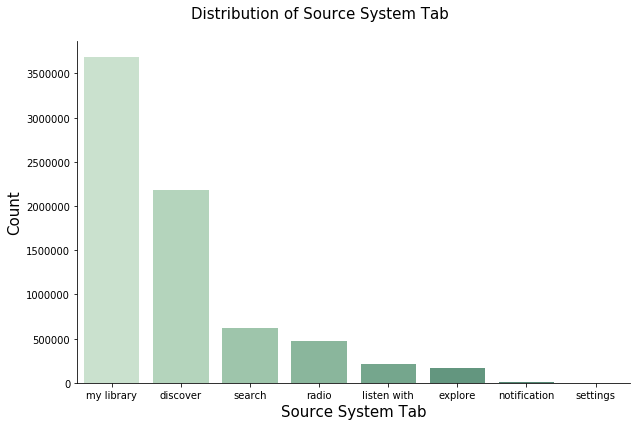

In [12]:
a = train.groupby('source_system_tab').size()
a = pd.DataFrame(a)
a.reset_index(level=0, inplace=True)
a.columns = ['Source System Tab', 'Count']
a = a.sort_values(by='Count', ascending=False)
print(a)
plt.rcParams["axes.labelsize"] = 15
ax = sns.catplot(x='Source System Tab', y='Count', kind='bar',
                 data=a, height=6, palette='ch:2.5,-.2,dark=.4', aspect=1.5)
ax.fig.suptitle('Distribution of Source System Tab', fontsize=15)
ax.fig.subplots_adjust(top=.9)
plt.show()


We can see that my library contributes to maximum of song events, followed by discover and search. This also looks intutive as we mostly use our libraries to listen to songs. Let us explore the same relation in respect of the repeat percentage to see which level of source system tab contributes maximum to repeat events.

                     target
source_system_tab          
my library         0.619659
settings           0.590909
explore            0.422146
search             0.421362
discover           0.415770
notification       0.378011
listen with        0.326581
radio              0.222662


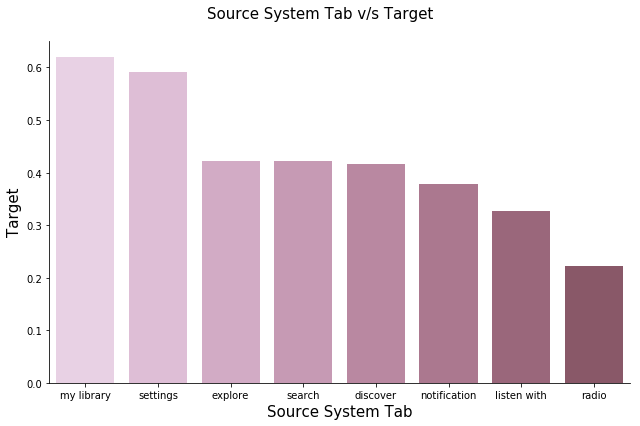

In [13]:
repeat_df = train.groupby(['source_system_tab']).mean(
).sort_values(by='target', ascending=False)
print(repeat_df)

repeat_df.reset_index(level=0, inplace=True)
repeat_df.columns = ['Source System Tab', 'Target']
plt.rcParams["axes.labelsize"] = 15
ax = sns.catplot(x='Source System Tab', y='Target', kind='bar', palette="ch:7,-.2,dark=.4",
                 data=repeat_df, height=6, aspect=1.5)
ax.fig.subplots_adjust(top=.9)
ax.fig.suptitle('Source System Tab v/s Target', fontsize=15)
plt.show()


As suspected, my library has maxmium repeat percentage followed by settings, explore, serach and discover. Note that settings and explore have less events yet have high conversions.

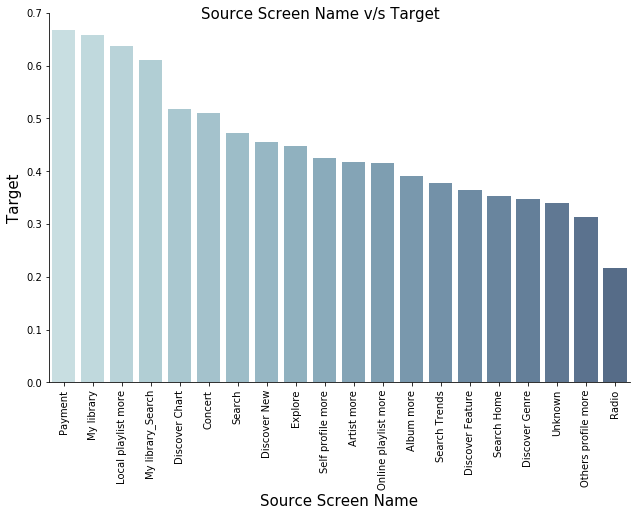

In [14]:
Name = train.groupby(['source_screen_name']).mean(
).sort_values(by='target', ascending=False)
Name.reset_index(level=0, inplace=True)
Name.columns = ['Source Screen Name', 'Target']
# print(Name)
plt.rcParams["axes.labelsize"] = 15
ax = sns.catplot(x='Source Screen Name', y='Target', kind='bar', palette="ch:12,-.2,dark=.4",
                 data=Name, height=6, aspect=1.5)
ax.fig.suptitle('Source Screen Name v/s Target', fontsize=15)
for ax in ax.axes.flat:
    plt.setp(ax.get_xticklabels(), rotation=90)

Similar to previous observation, Local playlist more has high events and repeat percentage

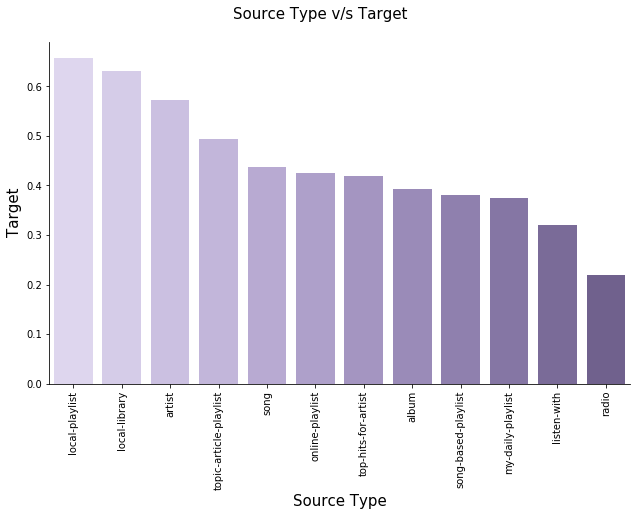

In [15]:
Type = train.groupby(['source_type']).mean(
).sort_values(by='target', ascending=False)
Type.reset_index(level=0, inplace=True)
Type.columns = ['Source Type', 'Target']
# print(Name)
plt.rcParams["axes.labelsize"] = 15
# Plot a simple histogram with binsize determined automatically
ax = sns.catplot(x='Source Type', y='Target', kind='bar', palette="ch:.12,0,dark=.4",
                 data=Type, height=6, aspect=1.5)
ax.fig.subplots_adjust(top=.9)
ax.fig.suptitle('Source Type v/s Target', fontsize=15)

for ax in ax.axes.flat:
    plt.setp(ax.get_xticklabels(), rotation=90)

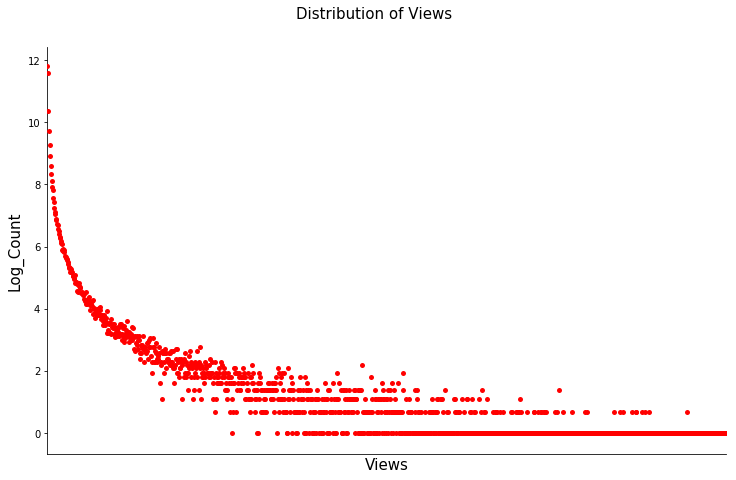

In [16]:
Type = train.groupby(['song_id']).sum().sort_values(
    by='target', ascending=False)
Type.reset_index(level=0, inplace=True)
Type.columns = ['Source Type', 'Views']

new = Type.groupby(['Views']).count()
new.reset_index(inplace=True)
new.columns = ['Views', 'Log_Count']
new['Log_Count'] = np.log(new.Log_Count)
plt.rcParams["axes.labelsize"] = 15
ax = sns.catplot(x='Views', y='Log_Count', kind='strip', color='red', height=7, aspect=1.5,
                 data=new)
ax.fig.subplots_adjust(top=.9)
ax.fig.suptitle('Distribution of Views', fontsize=15)
ax.set(xticks=[])
plt.show()

Understanding the relationship between variables and target variable. 

                     target
source_system_tab          
my library         0.619659
settings           0.590909
explore            0.422146
search             0.421362
discover           0.415770
notification       0.378011
listen with        0.326581
radio              0.222662


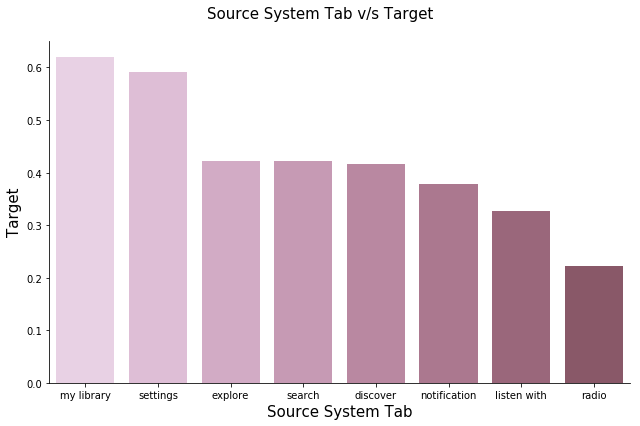

In [47]:
repeat_df = train.groupby(['source_system_tab']).mean(
).sort_values(by='target', ascending=False)
print(repeat_df)

repeat_df.reset_index(level=0, inplace=True)
repeat_df.columns = ['Source System Tab', 'Target']
plt.rcParams["axes.labelsize"] = 15
ax = sns.catplot(x='Source System Tab', y='Target', kind='bar', palette="ch:7,-.2,dark=.4",
                 data=repeat_df, height=6, aspect=1.5)
ax.fig.subplots_adjust(top=.9)
ax.fig.suptitle('Source System Tab v/s Target', fontsize=15)
plt.show()

Member data exploration

In [20]:
members.registration_init_time = pd.to_datetime(
    members.registration_init_time.astype('str'))
members.expiration_date = pd.to_datetime(members.expiration_date.astype('str'))

summary(members)

Total number of records:  34403
Distinct msno in dataframe: 34403
Distinct city in dataframe: 21
Distinct bd in dataframe: 95
Distinct gender in dataframe: 3
Distinct registered_via in dataframe: 6
Distinct registration_init_time in dataframe: 3862
Distinct expiration_date in dataframe: 1484


In [22]:
count_na(members)

,NA_count,Percentage
msno,0,0.000000
city,0,0.000000
bd,0,0.000000
gender,19902,57.849606
registered_via,0,0.000000
registration_init_time,0,0.000000
expiration_date,0,0.000000


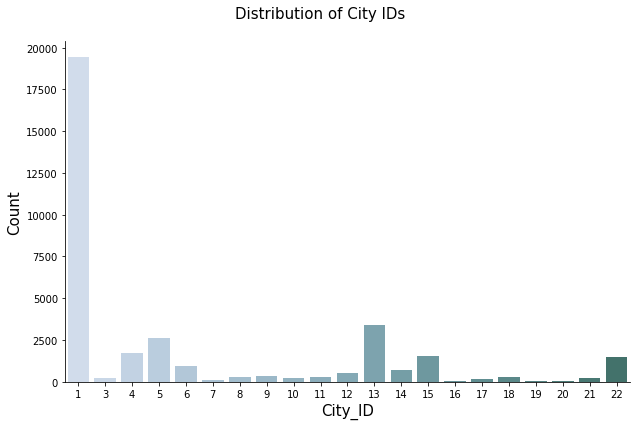

In [24]:
city = members.groupby(['city']).size()
city = pd.DataFrame(city)
city.reset_index(level=0, inplace=True)
city.columns = ['City_ID', 'Count']

plt.rcParams["axes.labelsize"] = 15
ax = sns.catplot(x='City_ID', y='Count', kind='bar', palette="ch:2,0.3,dark=.4",
                 data=city, height=6, aspect=1.5)
ax.fig.subplots_adjust(top=.9)
ax.fig.suptitle('Distribution of City IDs', fontsize=15)
plt.show()

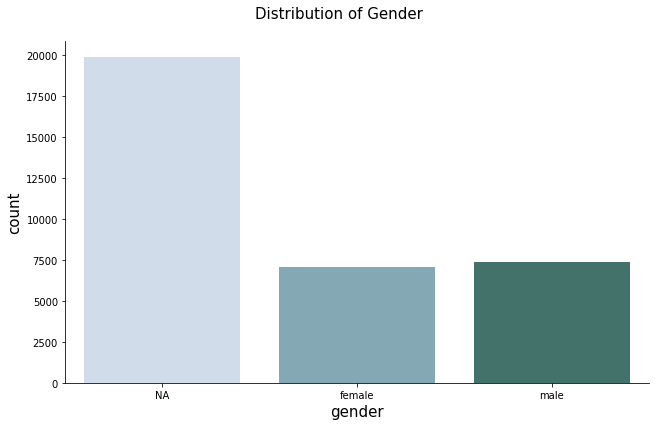

In [27]:
members['gender'] = members.gender.replace(np.NaN, 'NA')
plt.rcParams["axes.labelsize"] = 15
ax = sns.catplot(x='gender', kind='count', palette="ch:23,0.3,dark=.4",
                 data=members, height=6, aspect=1.5)
ax.fig.subplots_adjust(top=.9)
ax.fig.suptitle('Distribution of Gender', fontsize=15)
plt.show()

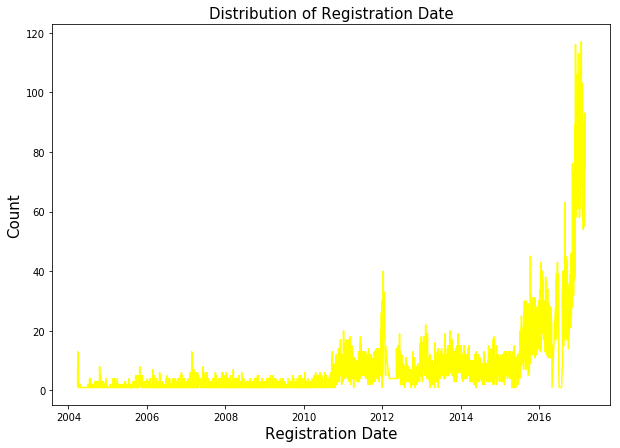

In [29]:
df = members['registration_init_time'].value_counts()
df.columns = ['Registration Date', 'Count']
plt.subplots(figsize=(10, 7))
plt.rcParams["axes.labelsize"] = 15
ax = sns.lineplot(data=df, color='yellow', size=20)
ax.set(xlabel='Registration Date', ylabel='Count')
ax.set_title("Distribution of Registration Date", fontsize=15)
plt.show()

Song Data Exploration

In [30]:
songs.head(5)

,song_id,song_length,genre_ids,artist_name,composer,lyricist,language
0,CXoTN1eb7AI+DntdU1vbcwGRV4SCIDxZu+YD8JP8r4E=,247640,465,張信哲 (Jeff Chang),董貞,何啟弘,3.0
1,o0kFgae9QtnYgRkVPqLJwa05zIhRlUjfF7O1tDw0ZDU=,197328,444,BLACKPINK,TEDDY| FUTURE BOUNCE| Bekuh BOOM,TEDDY,31.0
2,DwVvVurfpuz+XPuFvucclVQEyPqcpUkHR0ne1RQzPs0=,231781,465,SUPER JUNIOR,NaN,NaN,31.0
3,dKMBWoZyScdxSkihKG+Vf47nc18N9q4m58+b4e7dSSE=,273554,465,S.H.E,湯小康,徐世珍,3.0
4,W3bqWd3T+VeHFzHAUfARgW9AvVRaF4N5Yzm4Mr6Eo/o=,140329,726,貴族精選,Traditional,Traditional,52.0


In [31]:
summary(songs)

Total number of records:  2296320
Distinct song_id in dataframe: 2296320
Distinct song_length in dataframe: 146534
Distinct genre_ids in dataframe: 1046
Distinct artist_name in dataframe: 222363
Distinct composer in dataframe: 329824
Distinct lyricist in dataframe: 110926
Distinct language in dataframe: 11


In [32]:
count_na(songs)

,NA_count,Percentage
song_id,0,0.000000
song_length,0,0.000000
genre_ids,94116,4.098558
artist_name,0,0.000000
composer,1071354,46.655257
lyricist,1945268,84.712409
language,1,0.000044


In [65]:
language_name = {
    31:'Chinese',
    52:'English',
    -1:'White-Noise',
    3:'Chinese2',
    17:'Japanese',
    24:'Cantonese',
    10:'Taiwanese',
    45:'Thai',
    59:'Chinese',
    38:'English'
}

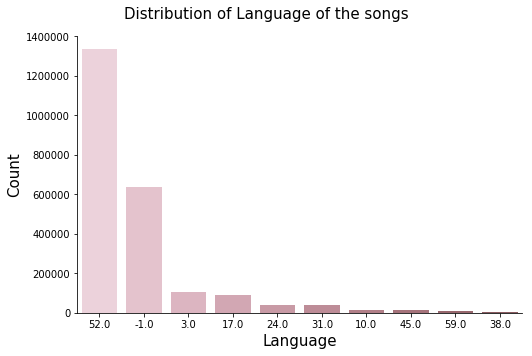

In [33]:
language = songs.groupby(['language']).size()
language = pd.DataFrame(language)
language.reset_index(level=0, inplace=True)
language.columns = ['Language', 'Count']
language = language.sort_values(by='Count', ascending=False)
language['Language'] = language['Language'].astype('str')

ax = sns.catplot(x='Language', y='Count', kind='bar', order=language['Language'],
                 palette="ch:10,-0.1,dark=.4", data=language, height=5, aspect=1.5)
ax.fig.subplots_adjust(top=.9)
ax.fig.suptitle('Distribution of Language of the songs', fontsize=15)
plt.show()

#ax.savefig('song_language.png')

count    2.296320e+06
mean     4.116558e+00
std      2.682000e+00
min      3.083333e-03
25%      3.060000e+00
50%      3.777117e+00
75%      4.621150e+00
max      2.028975e+02
Name: song_length, dtype: float64


Number of songs which have length greater than 10 minutes:37274


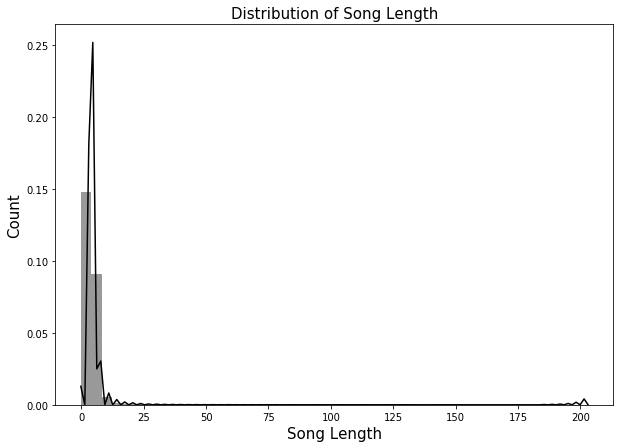

In [34]:
print((songs.song_length/6e4).describe())
print("\n")
print("Number of songs which have length greater than 10 minutes:{}".format(songs.query('song_length/6e4>10').shape[0]))
plt.subplots(figsize=(10, 7))
#x = ((songs.query('song_length/6e4<10')).song_length/6e4)
x = songs.song_length/6e4
ax = sns.distplot(x, color='black')
ax.set_title('Distribution of Song Length', fontsize=15)
ax.set(xlabel='Song Length', ylabel='Count')
plt.show()
# ax.savefig('song_length_wo_outliers.png')

count    2.296320e+06
mean     4.116558e+00
std      2.682000e+00
min      3.083333e-03
25%      3.060000e+00
50%      3.777117e+00
75%      4.621150e+00
max      2.028975e+02
Name: song_length, dtype: float64


Number of songs which have length greater than 10 minutes:37274


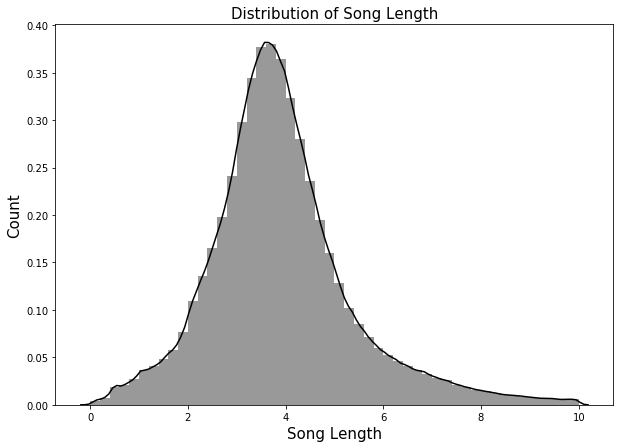

In [36]:
print((songs.song_length/6e4).describe())
print("\n")
print("Number of songs which have length greater than 10 minutes:{}".format(songs.query('song_length/6e4>10').shape[0]))
plt.subplots(figsize=(10, 7))
x = ((songs.query('song_length/6e4<10')).song_length/6e4)
#x = songs.song_length/6e4
ax = sns.distplot(x, color='black')
ax.set_title('Distribution of Song Length', fontsize=15)
ax.set(xlabel='Song Length', ylabel='Count')
plt.show()
# ax.savefig('song_length_wo_outliers.png')

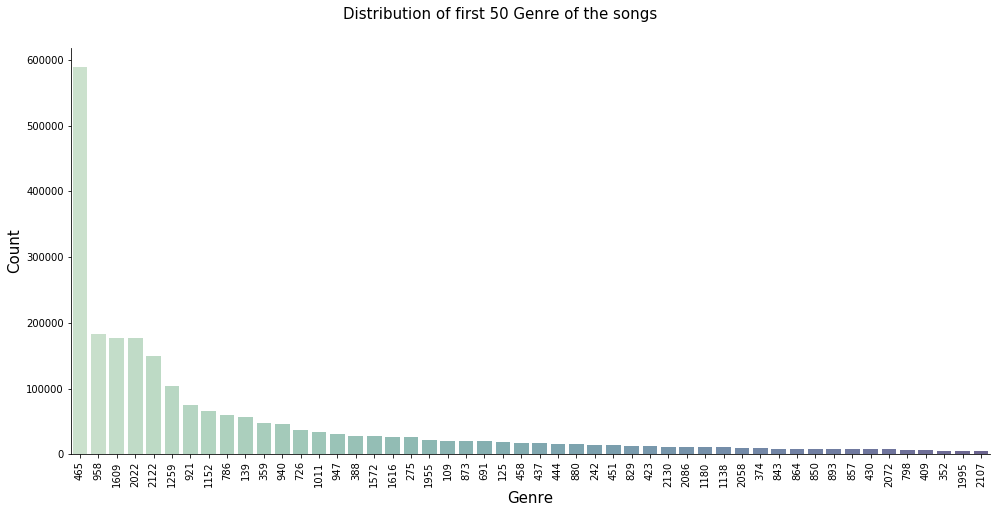

In [41]:
gener_count = genres_separate(songs.genre_ids)
gener_df = pd.DataFrame.from_dict(
    gener_count, orient='index', columns=['counts'])
gener_df.reset_index(level=0, inplace=True)
gener_df = gener_df.sort_values(by='counts', ascending=False)
gener_df.columns = ['Genre', 'Count']
gener_df = gener_df[0:50]
ax = sns.catplot(x='Genre', y='Count', kind='bar', order=gener_df['Genre'],
                 palette="ch:7,-0.8,dark=.4", data=gener_df, height=7, aspect=2)
ax.fig.subplots_adjust(top=.9)
ax.fig.suptitle('Distribution of first 50 Genre of the songs', fontsize=15)
for ax in ax.axes.flat:
    plt.setp(ax.get_xticklabels(), rotation=90)
plt.show()

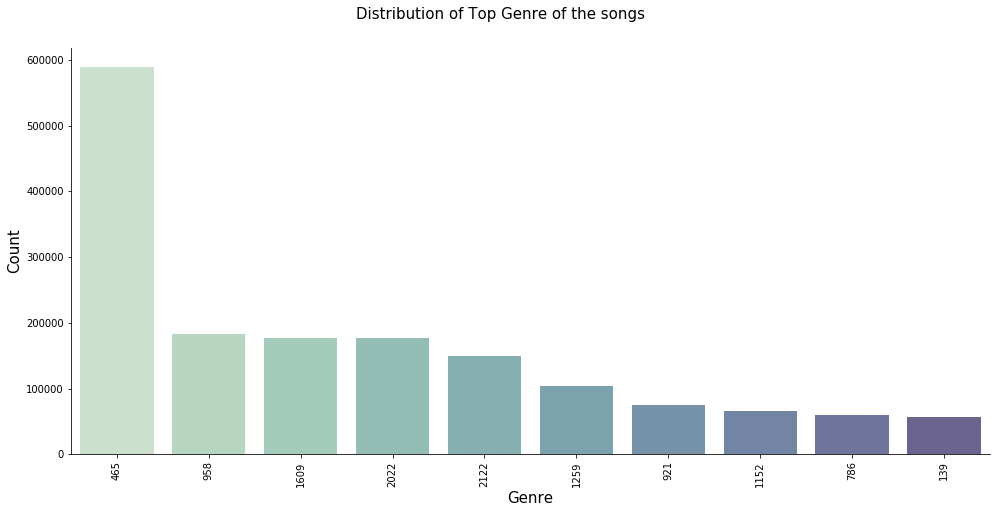

In [42]:
gener_count = genres_separate(songs.genre_ids)
gener_df = pd.DataFrame.from_dict(
    gener_count, orient='index', columns=['counts'])
gener_df.reset_index(level=0, inplace=True)
gener_df = gener_df.sort_values(by='counts', ascending=False)
gener_df.columns = ['Genre', 'Count']
gener_df = gener_df[0:10]
ax = sns.catplot(x='Genre', y='Count', kind='bar', order=gener_df['Genre'],
                 palette="ch:7,-0.8,dark=.4", data=gener_df, height=7, aspect=2)
ax.fig.subplots_adjust(top=.9)
ax.fig.suptitle('Distribution of Top Genre of the songs', fontsize=15)
for ax in ax.axes.flat:
    plt.setp(ax.get_xticklabels(), rotation=90)
plt.show()

In [43]:
listen_log = train[['msno',
                    'song_id',
                    'target']].merge(songs[['song_id',
                                            'artist_name',
                                            'genre_ids',
                                            'language']],
                                             on='song_id')

In [44]:
print('10 Most repeated artists:')
listen_log[listen_log.target==1].groupby('artist_name').size().nlargest(10).reset_index(name='count')

10 Most repeated artists:


,artist_name,count
0,Various Artists,154799
1,周杰倫 (Jay Chou),112227
2,五月天 (Mayday),101027
3,林俊傑 (JJ Lin),67621
4,田馥甄 (Hebe),60481
5,玖壹壹,43964
6,陳奕迅 (Eason Chan),43895
7,aMEI (張惠妹),41498
8,G.E.M.鄧紫棋,41423
9,謝和弦 (R-chord),36423


In [45]:
print('10 Most skipped artists:')
listen_log[listen_log.target==0].groupby('artist_name').size().nlargest(10).reset_index(name='count')

10 Most skipped artists:


,artist_name,count
0,Various Artists,148817
1,五月天 (Mayday),81061
2,周杰倫 (Jay Chou),74549
3,林俊傑 (JJ Lin),47704
4,田馥甄 (Hebe),44465
5,aMEI (張惠妹),41301
6,陳奕迅 (Eason Chan),32140
7,BIGBANG,26610
8,玖壹壹,26481
9,G.E.M.鄧紫棋,25873
